## Define a Model 

We can use carrot cdm to create destination tables and fields for our synthetic data model

In [1]:
from carrot cdm.objects.common import DestinationTable, DestinationField

class Demographics(DestinationTable):
    name = 'Demo'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Age = DestinationField(dtype="Integer", required=False)
        self.Sex = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)

class Symptoms(DestinationTable):
    name = 'Symptoms'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_occurrence = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.Headache = DestinationField(dtype="Text50", required=False )
        self.Fatigue = DestinationField(dtype="Text50", required=False )
        self.Dizzy = DestinationField(dtype="Text50", required=False )
        self.Cough = DestinationField(dtype="Text50", required=False )
        self.Fever = DestinationField(dtype="Text50", required=False )
        self.Muscle_Pain = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class GP_Records(DestinationTable):
    name = 'GP_Records'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_visit = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.comorbidity = DestinationField(dtype="Text50", required=False )
        self.comorbidity_value = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Hospital_Visit(DestinationTable):
    name = 'Hospital_Visit'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.admission_date = DestinationField(dtype="Timestamp", required=False)   
        self.reason = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Blood_Test(DestinationTable):
    name = 'Blood_Test'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_taken = DestinationField(dtype="Timestamp", required=False)   
        self.location = DestinationField(dtype="Text50", required=False )
        self.quantity = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Vaccinations(DestinationTable):
    name = 'Vaccinations'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_vaccination = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.type = DestinationField(dtype="Text50", required=False)
        self.stage = DestinationField(dtype="Integer", required=False)
        super().__init__(self.name,type(self).__name__) 
        
        
class Serology(DestinationTable):
    name = 'Serology'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Date = DestinationField(dtype="Timestamp", required=True)
        self.IgG = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)


Then build a total model(dataset) based upon these tables, creating this with 50k people

In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import io
import carrot nfrom carrot cdm import CommonDataModel
from carrot cdm import define_table

def create_gaus_time_series(mu,sigma,n):
    mu = time.mktime(mu.timetuple())
    sigma = (datetime.timedelta(**sigma)).total_seconds()
    return pd.Series([datetime.date.fromtimestamp(x) for x in np.random.normal(mu,sigma,n)])

class ExampleCovid19DataSet(CommonDataModel):
    def __init__(self):
        """                                                                                                                                                    
        initialise the inputs and setup indexing                                                                                                               
        """  
        #50k people
        n = 50000
        
        super().__init__(format_level=0)

        #create people indexes that we can use in the different tables
        self.people = pd.DataFrame([f'pk{i}' for i in range(1,n+1)],columns=['pks'])
        
        #set the processing order, e.g we want to build demographics table first
        #so that the values recorded in other tables can be demographically dependent 
        self.set_execution_order([
            'Demographics', 
            'GP_Records', 
            'Vaccinations',
            'Serology',
            'Symptoms',
            'Hospital_Visit',
            'Blood_Test'
        ])
        self.process()
      
    @define_table(Demographics)
    def demo(self):  
        """
        Straight foreward demographics
        """
        self.ID.series = self.cdm.people['pks']
        self.n = len(self.ID.series)
        self.Age.series = pd.Series(np.random.normal(60,20,self.n)).astype(int)
        self.Age.series = self.Age.series.mask(self.Age.series < 0 , None)
        self.Sex.series = pd.Series(np.random.choice(['Male','Female',None],size=self.n,p=[0.55,0.445,0.005]))
        
        
    @define_table(Symptoms)
    def symptoms(self):
        npeople = self.cdm.demo.n
        nsymptoms = npeople*5

        ID = self.cdm.demo.ID.series
        
        self.ID.series = ID.sample(int(npeople*0.8))\
            .sample(nsymptoms,replace=True)\
            .sort_values().reset_index(drop=True)  

        self.date_occurrence.series = create_gaus_time_series(mu=datetime.datetime(2021,1,1),
                                                              sigma={'days':365},
                                                              n=nsymptoms)
        
        self.date_occurrence.series.loc[self.date_occurrence.series.sample(frac=0.005).index] = np.nan
        
        syms_probs = {'Headache':0.8,'Fatigue':0.7,'Dizzy':0.4,'Cough':0.7,'Fever':0.2,'Muscle_Pain':0.1}
        for key,p in syms_probs.items():
            series = pd.Series(np.random.choice(['Yes','No'],size=nsymptoms,p=[p,1-p]))
            setattr(getattr(self,key),'series',series)
            
    @define_table(Serology)
    def serology(self):
        
        def calc_IgG(age,sex,nrisks):
            scale = 50*(1 - age/200)*(1.1 if sex=='Female' else 1.0)*(1/nrisks)
            return np.random.exponential(scale=scale)
        
        df_gp = self.cdm.gp.get_df()
        df_nrisks = df_gp['comorbidity'].groupby(df_gp.index)\
                    .count()
        df_nrisks.name ='nrisks'

        df = self.cdm.demo.get_df().join(df_nrisks).reset_index()
        df['nrisks'] = df['nrisks'].fillna(1)

        df = df[df['Age']>18].sample(frac=0.3)
        nstudies = len(df)

        df = df.sample(frac=1.4,replace=True).reset_index()

        df['IgG'] = df.apply(lambda x : calc_IgG(x.Age,x.Sex,x.nrisks),axis=1)
        df.sort_values('ID',inplace=True)
        
        self.IgG.series = df['IgG']
        self.ID.series = df['ID']
        self.Date.series = create_gaus_time_series(mu=datetime.datetime(2021,5,1),
                                                              sigma={'days':365},
                                                              n=len(df))
           
    @define_table(GP_Records)
    def gp(self):
    
        def calc_comoribidites(age):
            if pd.isna(age):
                return []   
            comorbidities = {
                'Mental Health':0.3*(1 + age/90) ,
                'Diabetes Type-II':0.15*(1 + age/70) ,
                'Heart Condition':0.1*(1 + age/50) ,
                'High Blood Pressure':0.07*(1 + age/60),
                'BMI': 1
            }
            return [x for x,p in comorbidities.items() if np.all(np.random.uniform() < p) ]
        
        #90% of people have a GP visit record
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        df['comorbidity'] = df.apply(lambda x: calc_comoribidites(x.Age),axis=1)
        df['date_of_observation'] = create_gaus_time_series(mu=datetime.datetime(2010,5,1),
                                                              sigma={'days':700},
                                                              n=len(df))
        
        df = df.explode('comorbidity').set_index('ID').sort_index()
    
        self.ID.series = df.index.to_series()
        self.comorbidity.series = df['comorbidity']
        self.comorbidity_value.series = df['comorbidity'].apply(lambda x: np.random.exponential(scale=20)
                                                                if x == 'BMI' else 1)
        self.date_of_visit.series = df['date_of_observation']
        
    @define_table(Hospital_Visit) 
    def hospital(self):
        
        n = len(self.cdm.demo.ID.series)
        
        #5% of people have had a hospital visit
        #some of those have multiple visists
        self.ID.series = self.cdm.demo.ID.series.sample(n)\
                        .sample(int(n*1.2),replace=True)\
                        .sort_values().reset_index(drop=True)  
        
        n = len(self.ID.series)
        self.admission_date.series = create_gaus_time_series(mu=datetime.datetime(2020,5,1),
                                                              sigma={'days':300},
                                                              n=n)
    
        reasons = {
            'Kidney Operation':0.1,
            'Appendix Operation':0.1,
            'Heart Attack':0.2,
            'COVID-19':0.15,
            'Pneumonia':0.15,
            'Cancer':0.3
        }

        self.reason.series = pd.Series(np.random.choice(list(reasons.keys()),size=n,p=list(reasons.values())))

    @define_table(Blood_Test)
    def bloods(self):
        #half of the people with hospital visits have blood taken
        df_hospital = self.cdm.hospital.get_df().sample(frac=0.5).reset_index()
        
        self.ID.series = df_hospital['ID']
        self.date_taken.series = pd.to_datetime(df_hospital['admission_date']) \
                               + datetime.timedelta(days=np.random.uniform(0,5))
        
        n = len(df_hospital)
        self.location.series = pd.Series(np.random.choice(['Right Arm','Left Arm','Small Intestine','Abdominal Wall'],
                                                   size=n,
                                                   p=[0.3,0.3,0.2,0.2]))
        self.quantity.series = pd.Series((np.random.exponential(scale=1.5) for _ in range(0,n)))
        
    @define_table(Vaccinations)
    def first_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #95% of people have had a vaccination
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  df.apply(lambda x : calc_date_of_vacc(x.Age),axis=1)
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((0 for _ in range(0,n)))
       
    @define_table(Vaccinations)
    def second_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #80% of people who had 1st had 2nd
        df = self.cdm.first_covid_vaccination.get_df().sample(frac=0.8).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  pd.to_datetime(df['date_of_vaccination']) \
                                           + datetime.timedelta(days=(50+np.random.uniform(0,50)))
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((1 for _ in range(0,n)))
        
        
     

## Create a Model
Create and run the model, for a dataset so large and complex, this can take some time

In [3]:
model = ExampleCovid19DataSet()
model

2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - CommonDataModel (5.3.1) created with co-connect-tools version 0.6.2
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Turning on automatic cdm column filling
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added bloods of type Blood_Test
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added demo of type Demographics
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added first_covid_vaccination of type Vaccinations
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added gp of type GP_Records
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added hospital of type Hospital_Visit
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added second_covid_vaccination of type Vaccinations
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added serology of type Serology
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Added symptoms of type Symptoms
2022-06-17 11:16:15 - ExampleCovid19DataSet - INFO - Starting pro

2022-06-17 11:16:22 - ExampleCovid19DataSet - INFO - called save_dateframe but outputs are not defined. save_files: True
2022-06-17 11:16:22 - ExampleCovid19DataSet - INFO - finalised Serology on iteration 0 producing 20583 rows from 1 tables
2022-06-17 11:16:22 - ExampleCovid19DataSet - INFO - for Symptoms: found 1 object
2022-06-17 11:16:22 - ExampleCovid19DataSet - INFO - working on Symptoms
2022-06-17 11:16:22 - ExampleCovid19DataSet - INFO - starting on symptoms
2022-06-17 11:16:23 - Symptoms - INFO - Not formatting data columns
2022-06-17 11:16:23 - Symptoms - INFO - created df (0x130b37d90)[symptoms]
2022-06-17 11:16:23 - ExampleCovid19DataSet - INFO - finished symptoms (0x130b37d90) ... 1/1 completed, 250000 rows
2022-06-17 11:16:23 - ExampleCovid19DataSet - ERROR - Removed 193424 row(s) due to duplicates found when merging Symptoms
2022-06-17 11:16:23 - ExampleCovid19DataSet - WARNING - Example duplicates...
2022-06-17 11:16:23 - ExampleCovid19DataSet - WARNING -      date_occ

## Viewing the Model

Print to see what output data tables the model contains

In [4]:
model.keys()

dict_keys(['Demographics', 'GP_Records', 'Vaccinations', 'Serology', 'Symptoms', 'Hospital_Visit', 'Blood_Test'])

retrieve the dataframes from the model

In [5]:
model['Demographics']

,Age,Sex
ID,,
pk1,78.0,Female
pk2,79.0,Female
pk3,62.0,Male
pk4,59.0,Female
pk5,87.0,Male
...,...,...
pk43088,55.0,None
pk43344,120.0,None
pk43698,139.0,Female


In [6]:
model['GP_Records']

,date_of_visit,comorbidity,comorbidity_value
ID,,,
pk1,2006-09-06,Mental Health,1.000000
pk1,2006-09-06,BMI,16.268096
pk100,2006-10-04,Mental Health,1.000000
pk100,2006-10-04,BMI,0.775664
pk1000,2010-01-22,Diabetes Type-II,1.000000
...,...,...,...
pk9995,2007-01-27,BMI,40.308474
pk9996,2009-10-29,BMI,1.669654
pk9997,2007-07-02,BMI,50.226284


In [7]:
model['Vaccinations']

,date_of_vaccination,type,stage
ID,,,
pk12079,2021-07-02 04:10:39.789592,Pfizer,0
pk23041,2021-08-06 19:33:56.331029,Pfizer,0
pk29149,2021-07-22 18:41:35.147637,Moderna,0
pk33269,2021-06-22 17:51:02.611309,AstraZenica,0
pk1529,2021-06-07 18:55:24.734325,AstraZenica,0
...,...,...,...
pk26337,2021-10-28 19:43:15.932084,Pfizer,1
pk28147,2021-10-20 23:24:31.597765,Pfizer,1
pk17197,2021-11-24 11:02:16.031721,AstraZenica,1


In [8]:
model['Serology']

,Date,IgG
ID,,
pk1,2022-04-06,20.482169
pk1,2023-04-08,27.317406
pk1,2023-02-06,40.826386
pk1000,2020-05-27,129.956429
pk1000,2021-07-04,113.748108
...,...,...
pk9991,2020-12-30,25.077753
pk9993,2019-09-18,11.531673
pk9993,2021-10-27,48.985263


In [9]:
model['Symptoms']

,date_occurrence,Headache,Fatigue,Dizzy,Cough,Fever,Muscle_Pain
ID,,,,,,,
pk1,2019-06-11,Yes,Yes,No,Yes,No,No
pk1,2020-04-26,Yes,Yes,No,Yes,No,Yes
pk1,2021-05-31,Yes,No,Yes,Yes,Yes,No
pk1,2020-11-30,Yes,No,Yes,Yes,No,No
pk1,2022-02-02,Yes,Yes,No,Yes,Yes,No
...,...,...,...,...,...,...,...
pk9985,2020-11-05,No,Yes,No,No,Yes,No
pk9986,2019-03-31,Yes,No,Yes,Yes,No,No
pk9986,2020-07-08,Yes,No,No,No,No,Yes


In [10]:
model['Blood_Test']

,date_taken,location,quantity
ID,,,
pk9787,2020-04-09 20:52:33.560570,Small Intestine,1.208522
pk32023,2020-05-25 20:52:33.560570,Left Arm,0.692567
pk5495,2020-08-16 20:52:33.560570,Abdominal Wall,2.203956
pk18225,2020-09-13 20:52:33.560570,Left Arm,0.216205
pk47688,2022-06-28 20:52:33.560570,Small Intestine,0.065752
...,...,...,...
pk30942,2019-08-30 20:52:33.560570,Small Intestine,0.105680
pk44976,2020-09-18 20:52:33.560570,Small Intestine,0.815650
pk20331,2018-12-14 20:52:33.560570,Right Arm,4.176950


In [11]:
model['Hospital_Visit']

,admission_date,reason
ID,,
pk1,2020-07-18,Heart Attack
pk1,2019-06-09,Cancer
pk1,2020-07-03,Cancer
pk100,2020-04-14,Pneumonia
pk10000,2020-11-13,Heart Attack
...,...,...
pk9953,2018-07-14,COVID-19
pk9957,2022-02-01,COVID-19
pk9963,2023-05-08,Kidney Operation


## Perform analysis

Firstly get the the GP records, and count the number of comorbidities a patient has, to create risk groups

In [12]:
df_gp = model['GP_Records']
df_nrisks = df_gp.groupby(df_gp.index)['comorbidity'].count() 
df_nrisks.name = 'nrisks'
df_nrisks.value_counts().to_frame().sort_index()

,nrisks
0,46
1,35685
2,7089
3,1816
4,342
5,22


build a dataframe for analysis by getting the serology data + demographics data + the number of risks

In [13]:
df = model['Serology'].join(model['Demographics']).join(df_nrisks).fillna(0)
df

,Date,IgG,Age,Sex,nrisks
ID,,,,,
pk1,2022-04-06,20.482169,78.0,Female,2.0
pk1,2023-04-08,27.317406,78.0,Female,2.0
pk1,2023-02-06,40.826386,78.0,Female,2.0
pk1000,2020-05-27,129.956429,0.0,0,2.0
pk1000,2021-07-04,113.748108,0.0,0,2.0
...,...,...,...,...,...
pk9991,2020-12-30,25.077753,0.0,0,1.0
pk9993,2019-09-18,11.531673,0.0,0,1.0
pk9993,2021-10-27,48.985263,0.0,0,1.0


Produce some plots show how there is a difference in the IgG response for different age and risk groups

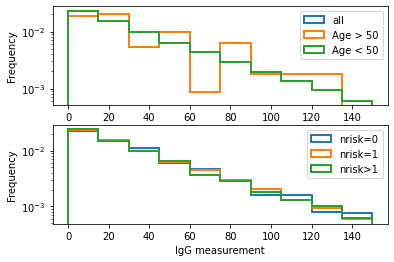

In [14]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(2)
ax = axs[0]

df['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),histtype='step',lw=2,density=True,label='all')
df[df['Age']>50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age > 50')
df[df['Age']<50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age < 50')
ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()

ax = axs[1]
df[df['nrisks']<1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=0')
df[df['nrisks']==1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=1')
df[df['nrisks']>1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk>1')

ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()
plt.show();